In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files Using Stream

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email body extraction

In [5]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [7]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00422.7d5baf3fe64de8647b41aeb820ada876,Hello\n\n\n\nYou may have seen this business b...,1
00432.40ceb2dcb26e292ea6fd8669dfc9b4c5,FROM: KONE BAKAR\n\nTEL: (+225) 0771 1719. \n...,1
00253.83b95b05e275286eddcf557ea581e754,There is NO stumbling on to it! \n\n\n\nThe gr...,1
00454.1bb460b3ade9801644e4eb60e18d1f8d,This is a multi-part message in MIME format.\n...,1
00021.effe1449462a9d7ad7af0f1c94b1a237,CENTRAL BANK OF NIGERIA\n\nFOREIGN REMITTANCE ...,1


In [8]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [9]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

## Cleaning the data and filling the missing values

In [10]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [11]:
data.drop(['cmds'], inplace=True)

data[4608:4611]

,MESSAGE,CATEGORY
01139.7d9591cdfb9b77906c4bbb7373cac8c5,"Once upon a time, Brian wrote :\n\n\n\n> A...",0
00350.e738a16c1483dfda97d5862b4a9a77f8,"\n\n""John P. Looney"" <valen@tuatha.org> a écri...",0
00478.e7beb5a43fcf1ac2a87b4ce4fdcd9b32,"I missed this previously, but\n\nthe Gobe prod...",0


## Adding documnet IDs.

In [12]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [13]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,Hello\n\n\n\nYou may have seen this business b...,1,00422.7d5baf3fe64de8647b41aeb820ada876
1,FROM: KONE BAKAR\n\nTEL: (+225) 0771 1719. \n...,1,00432.40ceb2dcb26e292ea6fd8669dfc9b4c5
2,There is NO stumbling on to it! \n\n\n\nThe gr...,1,00253.83b95b05e275286eddcf557ea581e754
3,This is a multi-part message in MIME format.\n...,1,00454.1bb460b3ade9801644e4eb60e18d1f8d
4,CENTRAL BANK OF NIGERIA\n\nFOREIGN REMITTANCE ...,1,00021.effe1449462a9d7ad7af0f1c94b1a237


## Saving Dataframe into a json

In [14]:
data.to_json(DATA_JSON_FILE)

# Data visualisation in matplotlib

## View no of ham and spam email

In [15]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [16]:
number_of_ham = data.CATEGORY.value_counts()[0]
number_of_spam = data.CATEGORY.value_counts()[1]

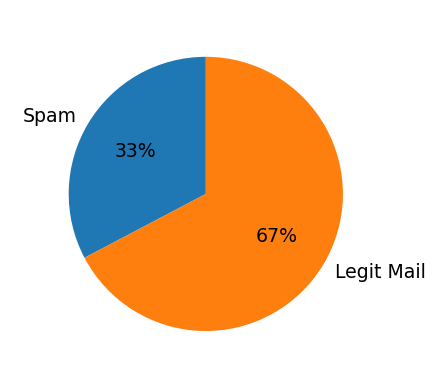

In [17]:
category_names = ['Spam', 'Legit Mail']
sizes = [number_of_spam, number_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct="%1.0f%%")
plt.show()

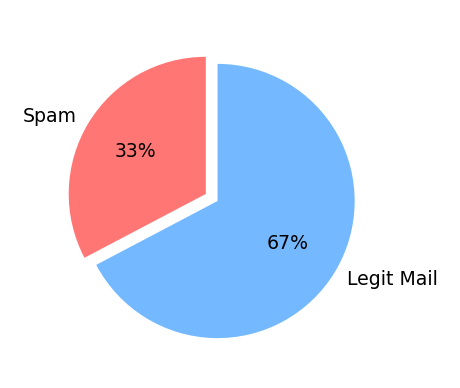

In [18]:
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

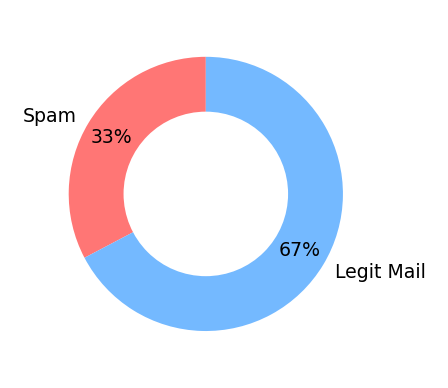

In [19]:
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# NLP (Natural Language Proccessing)

## Downloading important NLTK Resources (Tokenizer and Stopwords)

In [20]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('gutenberg')
# nltk.download('shakespeare')

## Email Proccessing renoving stopwords,  stemming and removing html tags.

In [21]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())

    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

print("herllo")

herllo


In [22]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['stumbl',
 'greatest',
 'way',
 'market',
 'centuri',
 'undoubtedli',
 'direct',
 'similar',
 'postman',
 'deliv',
 'letter',
 'mailbox',
 'abil',
 'promot',
 'product',
 'servic',
 'websit',
 'market',
 'opportun',
 'million',
 'instantli',
 'advertis',
 'dream',
 'year',
 'promot',
 'list',
 'address',
 'greatest',
 'part',
 'complet',
 'afford',
 'market',
 'answer',
 'know',
 'know',
 'exactli',
 'proven',
 'fact',
 'attract',
 'new',
 'busi',
 'direct',
 'market',
 'profit',
 'advertis',
 'gener',
 'amaz',
 'live',
 'proof',
 'direct',
 'internet',
 'advertis',
 'compani',
 'client',
 'pay',
 'us',
 'thousand',
 'dollar',
 'week',
 'product',
 'servic',
 'standard',
 'price',
 'procedur',
 'extract',
 'list',
 'gener',
 'internet',
 'address',
 'actual',
 'extract',
 'popular',
 'web',
 'site',
 'internet',
 'address',
 'verifi',
 'run',
 'purif',
 'process',
 'process',
 'includ',
 'address',
 'run',
 'custom',
 'remov',
 'filter',
 'keyword',
 'well',
 'remov',
 'flamer',
 'lis

In [23]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/home/suyash/env/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 2min 52s, sys: 755 ms, total: 2min 53s
Wall time: 2min 53s


In [24]:
len(nested_list)

5796

In [25]:
# indices of the two different category
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a series with a index

In [26]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [27]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [28]:
nested_list_ham.head()

DOC_ID
1896    [hi, folk, instal, updat, fail, use, instal, p...
1897    [upon, time, lanc, wrote, fail, depend, rpm, d...
1898    [wed, oct, jason, jason, renni, wrote, jason, ...
1899    [interest, quot, http, thoma, jefferson, exami...
1900    [tue, aug, jon, wrote, given, old, toshiba, ea...
Name: MESSAGE, dtype: object

In [29]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [30]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

13242

# Generate Vocabulary and Dictionary

In [31]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [32]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.shape[0]

27334

In [33]:
unique_words.head()

http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [34]:
frequent_words = unique_words[0:2500]
frequent_words.head()
frequent_words.shape

(2500,)

In [35]:
type(frequent_words)

pandas.core.series.Series

## Create Vocabulary DataFrame with a WORD_ID

In [36]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'

In [37]:
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [38]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

#### Coding challenges for finding a name in list, longest email in list and using argmax function

In [39]:
any(vocab.VOCAB_WORD == "free") # inefficient way

"machine" in set(vocab.VOCAB_WORD) # efficient way for checking membership

clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
max(clean_email_length)

np.argmax(clean_email_length)

5760

In [40]:
stemmed_nested_list

DOC_ID
0       [hello, may, seen, busi, ignor, know, mani, ti...
1       [kone, bakar, tel, abidjan, ivori, coast, dear...
2       [stumbl, greatest, way, market, centuri, undou...
3       [messag, mime, format, financi, power, depend,...
4       [central, bank, nigeria, foreign, remitt, dept...
                              ...                        
5791    [robert, elz, date, wed, aug, kind, doubt, pre...
5792    [well, play, around, strang, wav, file, realis...
5793    [date, thu, aug, lar, heck, quicki, shell, scr...
5794    [partit, ambigu, term, think, know, mean, look...
5795    [could, tri, eliv, http, pm, adrian, murphi, w...
Name: MESSAGE, Length: 5796, dtype: object

## Generate Features and Sparse Matrix

In [41]:
stemmed_nested_list.to_list()

[['hello',
  'may',
  'seen',
  'busi',
  'ignor',
  'know',
  'mani',
  'time',
  'howev',
  'pleas',
  'take',
  'moment',
  'read',
  'letter',
  'amaz',
  'profit',
  'potenti',
  'busi',
  'final',
  'sunk',
  'work',
  'tool',
  'success',
  'busi',
  'fast',
  'easi',
  'well',
  'within',
  'capabl',
  'ordinari',
  'peopl',
  'know',
  'littl',
  'internet',
  'market',
  'earn',
  'potenti',
  'truli',
  'stagger',
  'make',
  'promis',
  'read',
  'end',
  'follow',
  'say',
  'letter',
  'worri',
  'whether',
  'recess',
  'come',
  'presid',
  'whether',
  'keep',
  'current',
  'job',
  'ye',
  'know',
  'think',
  'never',
  'respond',
  'one',
  'either',
  'one',
  'day',
  'though',
  'someth',
  'said',
  'throw',
  'away',
  'go',
  'movi',
  'hour',
  'wife',
  'heck',
  'believ',
  'matter',
  'believ',
  'feel',
  'come',
  'thank',
  'everi',
  'day',
  'feel',
  'imagin',
  'would',
  'would',
  'read',
  'true',
  'everi',
  'word',
  'legal',
  'check',
  'si

In [42]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,hello,may,seen,busi,ignor,know,mani,time,howev,pleas,...,None,None,None,None,None,None,None,None,None,None
1,kone,bakar,tel,abidjan,ivori,coast,dear,permit,inform,desir,...,None,None,None,None,None,None,None,None,None,None
2,stumbl,greatest,way,market,centuri,undoubtedli,direct,similar,postman,deliv,...,None,None,None,None,None,None,None,None,None,None
3,messag,mime,format,financi,power,depend,competit,guarante,year,let,...,None,None,None,None,None,None,None,None,None,None
4,central,bank,nigeria,foreign,remitt,dept,tinubu,squar,lago,nigeria,...,None,None,None,None,None,None,None,None,None,None


In [43]:
word_columns_df.shape

(5796, 7671)

## Spliting the Data into trainig and Testing Dataset

In [47]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,test_size=0.3, random_state=42)

In [48]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4844,fri,aug,torsten,bronger,wrote,creat,rpm,accord,one,red,...,None,None,None,None,None,None,None,None,None,None
4727,michel,alexandr,salim,wrote,instal,limbo,sidetrack,work,limbo,run,...,None,None,None,None,None,None,None,None,None,None
5022,sun,aug,russel,turpin,wrote,rogu,app,machin,keep,snif,...,None,None,None,None,None,None,None,None,None,None
3504,hi,anyon,ever,tri,connect,linux,got,usr,faxmodem,meant,...,None,None,None,None,None,None,None,None,None,None
3921,hello,hear,razor,plugin,mozilla,plugin,would,add,report,spam,...,None,None,None,None,None,None,None,None,None,None


In [51]:
X_train.index.name = X_test.index.name = "DOC_ID"

In [52]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,mean,like,mac,keyboard,microsoft,usb,keyboard,ms,internet,pro,...,None,None,None,None,None,None,None,None,None,None
4220,pm,ed,greenberg,wrote,pm,dan,wrote,natur,patent,put,...,None,None,None,None,None,None,None,None,None,None
2484,hi,wed,sep,yannick,gingra,wrote,btw,thank,provid,interestiong,...,None,None,None,None,None,None,None,None,None,None
2418,gari,lawrenc,murphi,ok,also,meant,religi,alcohol,extrem,sinc,...,None,None,None,None,None,None,None,None,None,None
5110,wed,jul,tabor,well,wrote,tue,jul,patrick,thought,said,...,None,None,None,None,None,None,None,None,None,None


In [53]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [54]:
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'bond', 'maxaman', 'till', 'quarter', 'layer', 'freez', 'multimedia',
       'apach', 'analog', 'wisdom'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set(indexed_words)
    